**Import Modules**

In [18]:
# Import necessary libraries
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Data handling and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Activation,
                                     Dropout, BatchNormalization)
from tensorflow.keras import regularizers

# For ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
# For EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

from tensorflow.keras.utils import plot_model


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

import h5py
print(f"HDF5 version: {h5py.version.hdf5_version}")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

HDF5 version: 1.12.1
Num GPUs Available:  1


**Data Handling Functions**

In [19]:
# Function to get file paths and labels from a directory
def get_filepaths_and_labels(directory):
    """
    Generate file paths and labels from a directory.

    Args:
        directory (str): The root directory containing class subdirectories.

    Returns:
        list: List of file paths.
        list: Corresponding list of labels.
    """
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} not found.")

    filepaths, labels = [], []

    for class_label in os.listdir(directory):
        class_dir = os.path.join(directory, class_label)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                if os.path.isfile(filepath):
                    filepaths.append(filepath)
                    labels.append(class_label)
    return filepaths, labels

# Function to create a DataFrame from file paths and labels
def create_dataframe(filepaths, labels):
    """
    Create a pandas DataFrame from file paths and labels.

    Args:
        filepaths (list): List of file paths.
        labels (list): List of labels.

    Returns:
        pd.DataFrame: DataFrame with columns 'filepaths' and 'labels'.
    """
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Function to load dataframes for training, validation, and testing
def load_dataframes(root_dir, val_dir=None, test_dir=None):
    """
    Load dataframes for training, validation, and testing.

    Args:
        root_dir (str): Directory containing training data or all data if val_dir and test_dir are None.
        val_dir (str): Directory containing validation data.
        test_dir (str): Directory containing test data.

    Returns:
        tuple: (train_df, val_df, test_df)
    """
    if val_dir and test_dir:
        # All directories are provided
        train_files, train_labels = get_filepaths_and_labels(root_dir)
        val_files, val_labels = get_filepaths_and_labels(val_dir)
        test_files, test_labels = get_filepaths_and_labels(test_dir)
        train_df = create_dataframe(train_files, train_labels)
        val_df = create_dataframe(val_files, val_labels)
        test_df = create_dataframe(test_files, test_labels)
    elif test_dir:
        # Only train and test directories are provided
        train_files, train_labels = get_filepaths_and_labels(root_dir)
        test_files, test_labels = get_filepaths_and_labels(test_dir)
        full_df = create_dataframe(train_files, train_labels)
        # Split train_df into train and val
        train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=123, stratify=full_df['labels'])
        test_df = create_dataframe(test_files, test_labels)
    else:
        # Only root_dir is provided
        files, labels = get_filepaths_and_labels(root_dir)
        full_df = create_dataframe(files, labels)
        # Split into train, val, test
        train_df, temp_df = train_test_split(full_df, test_size=0.2, random_state=123, stratify=full_df['labels'])
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=123, stratify=temp_df['labels'])
    return train_df, val_df, test_df


**Function to Reduce Dataset Size**

In [20]:
# Function to reduce the dataset size for faster computation
def reduce_dataset(df, samples_per_class=500):
    """
    Reduce the dataset size by sampling a fixed number of images per class.

    Args:
        df (pd.DataFrame): DataFrame containing 'labels' column.
        samples_per_class (int): Number of samples to keep per class.

    Returns:
        pd.DataFrame: Reduced DataFrame.
    """
    # Randomly sample a fixed number of images per class
    reduced_df = df.groupby('labels', group_keys=False).apply(
        lambda x: x.sample(min(len(x), samples_per_class), random_state=42)
    ).reset_index(drop=True)
    return reduced_df

**Function to generate images from dataframe**

In [21]:
def create_image_generators(train_df, val_df, test_df, batch_size=40, img_size=(224, 224), preprocessing_function=None):
    tr_gen = ImageDataGenerator(preprocessing_function=preprocessing_function, horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )
    val_gen = ts_gen.flow_from_dataframe(
        val_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False
    )
    return train_gen, val_gen, test_gen

**Function to display sample images**

In [22]:
def display_sample_images(generator, num_images=25):
    """
    Display a grid of sample images from the generator.

    Args:
        generator: ImageDataGenerator.
        num_images (int): Number of images to display.

    Returns:
        None
    """
    # Get class labels
    class_labels = list(generator.class_indices.keys())
    images, labels = next(generator)

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = images[i] / 255.0
        plt.imshow(img)
        idx = np.argmax(labels[i])
        plt.title(class_labels[idx], color='green')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

**Function to plot class distributions**

In [23]:
def plot_class_distribution(df, title='Class Distribution'):
    """
    Plot the distribution of classes in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'labels' column.
        title (str): Title of the plot.

    Returns:
        None
    """
    class_counts = df['labels'].value_counts()
    plt.figure(figsize=(16, 8))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.show()
    

**Callback Functions**

Helpful functions to help optimize model training

In [24]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs=None):
        msg = 'Do you want the model to ask you to halt the training [y/n]?'
        print(msg)
        ans = input('').strip().lower()
        if ans == 'y':
            self.ask_permission = 1
        elif ans == 'n':
            self.ask_permission = 0
        else:
            print("Invalid input. Defaulting to 'no'.")
            self.ask_permission = 0  # Default value

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    #def on_train_batch_end(self, batch, logs=None):
        # Print every N batches (e.g., every 100 batches)
    #    N = 100
    #    if (batch + 1) % N == 0:
    #        acc = logs.get('accuracy') * 100
    #        loss = logs.get('loss')
    #        msg = f'Batch {batch + 1}/{self.batches} - accuracy: {acc:.2f}% - loss: {loss:.5f}'
    #        print(msg)


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

**Function to build models**

In [25]:
def build_efficientnet_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='max'
    )
    base_model.trainable = True  # Make sure to set this before compiling

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256,
              kernel_regularizer=regularizers.l2(0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),
              activation='relu'),
        Dropout(rate=0.45, seed=123),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def build_resnet50_model(input_shape, num_classes):
    """
    Build a CNN model using ResNet50 as base.

    Args:
        input_shape (tuple): Input image shape.
        num_classes (int): Number of output classes.

    Returns:
        keras.Model: Compiled model.
    """
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    # Allow the base model to be trainable
    base_model.trainable = True

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)  # Removed training=False
    x = BatchNormalization()(x)
    x = Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006)
    )(x)
    x = Dropout(rate=0.45, seed=123)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


**Function to plot training history**

In [26]:
def plot_training_history(history, title='Training and Validation Metrics'):
    """
    Plot the training and validation accuracy and loss.

    Args:
        history (keras.callbacks.History): History object from model training.
        title (str): Title of the plot.

    Returns:
        None
    """
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

**Function to evaluate model**

In [27]:
def evaluate_model(model, test_gen):
    """
    Evaluate the model on test data and print classification report and confusion matrix.

    Args:
        model (keras.Model): Trained model.
        test_gen (ImageDataGenerator): Test data generator.

    Returns:
        None
    """
    # Predict classes
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes

    # Get class names
    class_labels = list(test_gen.class_indices.keys())

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


**Function to display predictions**

In [28]:
def display_predictions(generator, model, num_images=15):
    """
    Display images with predicted and true labels.

    Args:
        generator (ImageDataGenerator): Data generator.
        model (keras.Model): Trained model.
        num_images (int): Number of images to display.

    Returns:
        None
    """
    images, labels = next(generator)
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(labels, axis=1)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        img = images[i] / 255.0
        plt.imshow(img)
        pred_label = class_labels[y_pred[i]]
        true_label = class_labels[y_true[i]]
        color = 'green' if y_pred[i] == y_true[i] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


### Model Structure

**Load and Prepare Data**

In [29]:
# Set data directories
train_dir = '../data/raw/crop/'
val_dir = ''  # or None
test_dir = ''  # or None

# Load dataframes
try:
    train_df, val_df, test_df = load_dataframes(train_dir, val_dir, test_dir)
    
    # Optionally, reduce the dataset size for quicker training
    train_df = reduce_dataset(train_df, samples_per_class=300)  # Adjust as needed
    val_df = reduce_dataset(val_df, samples_per_class=30)
    test_df = reduce_dataset(test_df, samples_per_class=30)
    
    # Create image generators
    batch_size = 32
    
    train_gen_resnet, val_gen_resnet, test_gen_resnet = create_image_generators(
    train_df, val_df, test_df,
    batch_size=batch_size,
    img_size=(224,224),
    preprocessing_function=resnet_preprocess)
    
    train_gen_eff, val_gen_eff, test_gen_eff = create_image_generators(
    train_df, val_df, test_df,
    batch_size=batch_size,
    img_size=(224,224),
    preprocessing_function=efficientnet_preprocess)
    
except Exception as e:
    print(f"Error: {e}")

Found 14535 validated image filenames belonging to 60 classes.
Found 1555 validated image filenames belonging to 60 classes.
Found 1544 validated image filenames belonging to 60 classes.
Found 14535 validated image filenames belonging to 60 classes.
Found 1555 validated image filenames belonging to 60 classes.
Found 1544 validated image filenames belonging to 60 classes.


**Visualize Data**

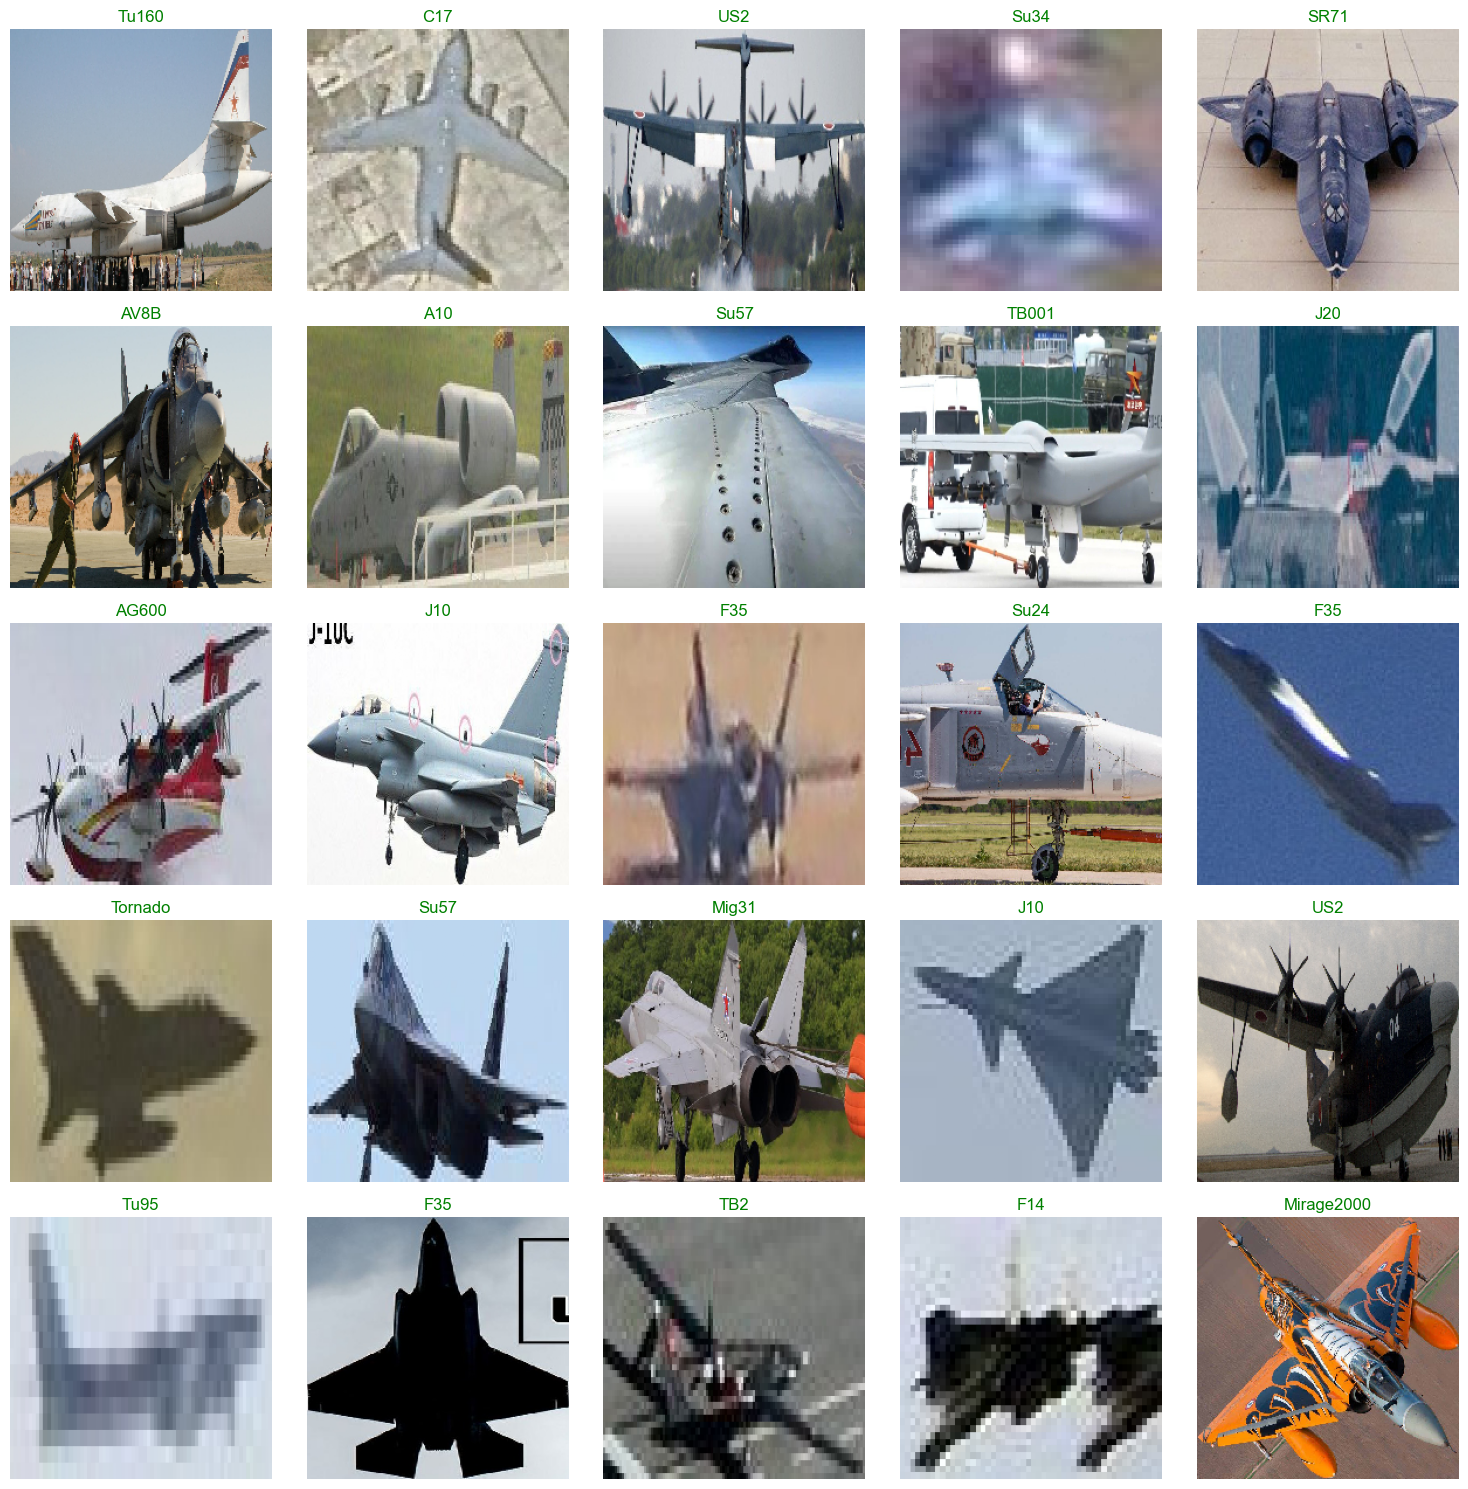

In [30]:
# Display sample images from the training set
display_sample_images(train_gen_eff, num_images=25)

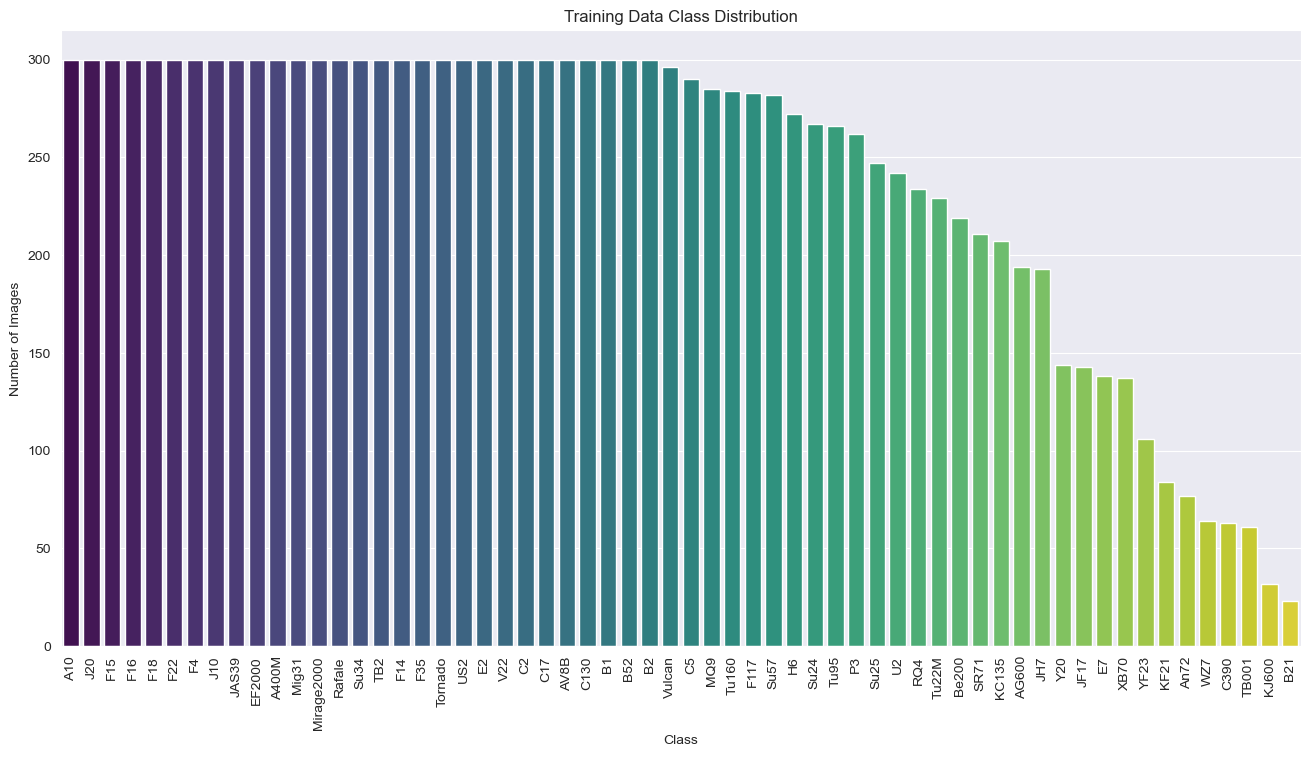

In [31]:
# Plot class distribution in the training data
plot_class_distribution(train_df, title='Training Data Class Distribution')

**Build and Compile Models**

In [32]:
# Build EfficientNetB3 model
img_size = (224, 224)
channels = 3
input_shape = img_size + (channels,)
num_classes = len(train_gen_eff.class_indices)

efficientnet_model = build_efficientnet_model(input_shape, num_classes)

# Build ResNet50 model
resnet_model = build_resnet50_model(input_shape, num_classes)


## Plotting models

In [33]:
plot_model(
    efficientnet_model,
    to_file='assets/efficientnet_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [34]:
plot_model(
    resnet_model,
    to_file='assets/resnet50_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96
)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [16]:
callbacks = [MyCallback(
    model=efficientnet_model,
    patience=1,
    stop_patience=3,
    threshold=0.9,
    factor=0.5,
    batches=int(np.ceil(len(train_gen_eff.labels) / batch_size)),
    epochs=40,
    ask_epoch=5
)]

In [17]:
# Create a new callback instance for ResNet50 model
callbacks_resnet = [MyCallback(
    model=resnet_model,
    patience=1,
    stop_patience=3,
    threshold=0.9,
    factor=0.5,
    batches=int(np.ceil(len(train_gen_resnet.labels) / batch_size)),
    epochs=20,  # Adjust epochs accordingly
    ask_epoch=5
)]

**Train EfficientNetB3 model**

Do you want the model to ask you to halt the training [y/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     8.878   18.122   5.92973  47.267   0.00100  0.00100  accuracy     0.00    251.76 
 2 /40     4.547   55.783   3.19947  70.997   0.00100  0.00100  accuracy    207.82   220.49 
 3 /40     2.535   76.099   2.01119  78.392   0.00100  0.00100  accuracy    36.42    217.71 
 4 /40     1.621   86.199   1.53575  82.830   0.00100  0.00100  accuracy    13.27    218.75 
 5 /40     1.160   91.854   1.27925  84.373   0.00100  0.00100  val_loss    16.70    216.82 
enter H to halt training or an integer for number of epochs to run then ask again
 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     0.921   94.723   1.15105  85.273   0.00100  0.00100  val_loss    10.02    277.58 
 7 /40     0.760   96.560   1.02569  87.010   0.00100  0.00100  val_loss    

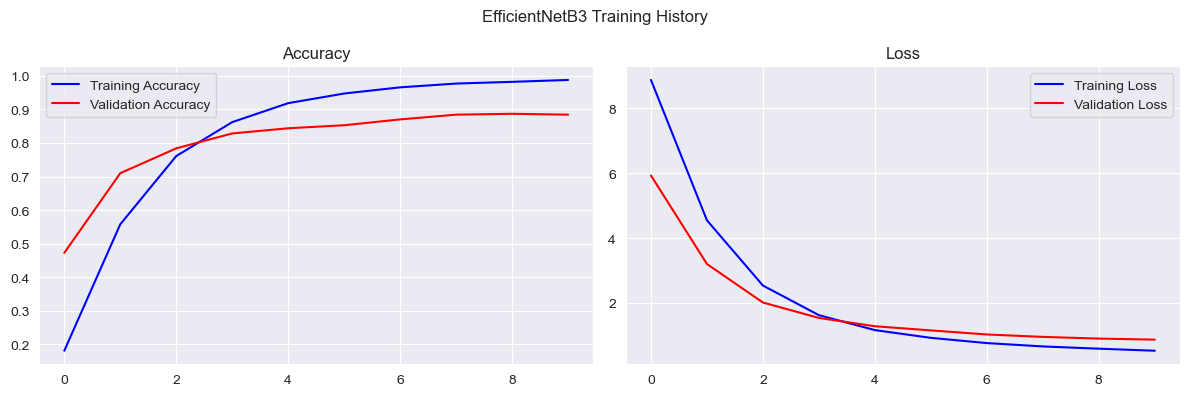

In [18]:
# Train EfficientNetB3 model
history_eff = efficientnet_model.fit(
    train_gen_eff,
    epochs=20,
    validation_data=val_gen_eff,
    callbacks=callbacks,
    verbose=0
)

# Plot training history for EfficientNetB3
plot_training_history(history_eff, title='EfficientNetB3 Training History')

**Train ResNet50 model**

Do you want the model to ask you to halt the training [y/n]?
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /20     9.582    2.951   9.93394   5.145   0.00100  0.00100  accuracy     0.00    170.16 
 2 /20     6.621    5.470   5.71170   7.138   0.00100  0.00100  accuracy    85.31    116.34 
 3 /20     4.947   14.214   4.52734  19.421   0.00100  0.00100  accuracy    159.87   118.74 
 4 /20     3.595   35.666   3.13858  44.952   0.00100  0.00100  accuracy    150.92   116.87 
 5 /20     2.611   57.097   2.49594  56.656   0.00100  0.00100  accuracy    60.09    116.77 
enter H to halt training or an integer for number of epochs to run then ask again
 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /20     1.970   72.590   2.12577  65.273   0.00100  0.00100  accuracy    27.14    158.91 
 7 /20     1.608   80.179   1.96995  68.810   0.00100  0.00100  accuracy    

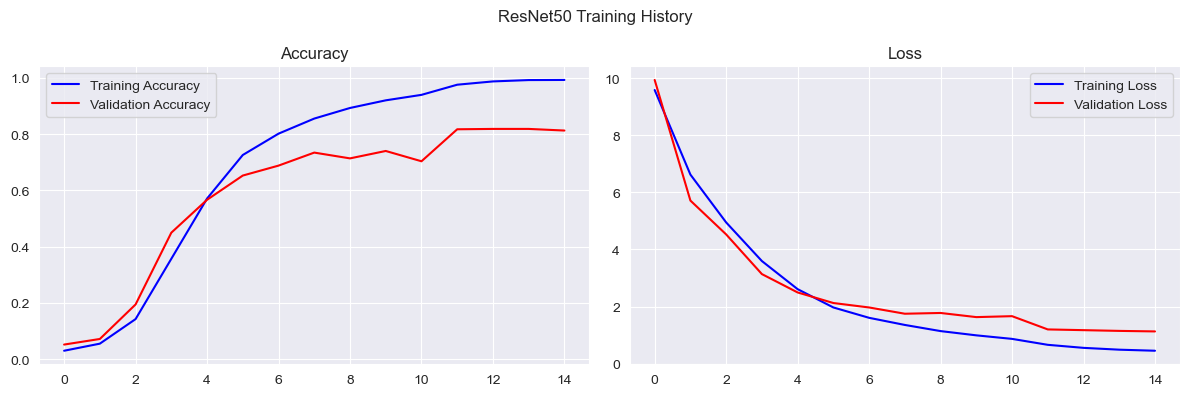

In [19]:
# Train ResNet50 model
history_resnet = resnet_model.fit(
    train_gen_resnet,
    epochs=20,
    validation_data=val_gen_resnet,
    callbacks=callbacks_resnet,
    verbose=0
)

# Plot training history for ResNet50
plot_training_history(history_resnet, title='ResNet50 Training History')

**Evaluate Models**

Evaluating EfficientNetB3 Model:
49/49 [==============================] - 19s 345ms/step
Classification Report:
              precision    recall  f1-score   support

         A10       0.86      0.80      0.83        30
       A400M       0.83      0.83      0.83        30
       AG600       0.95      0.88      0.91        24
        AV8B       0.93      0.90      0.92        30
        An72       0.62      0.89      0.73         9
          B1       0.92      0.80      0.86        30
          B2       0.97      0.97      0.97        30
         B21       1.00      0.50      0.67         2
         B52       0.93      0.93      0.93        30
       Be200       0.96      0.89      0.92        27
        C130       0.84      0.87      0.85        30
         C17       0.96      0.73      0.83        30
          C2       0.91      0.97      0.94        30
        C390       0.86      0.86      0.86         7
          C5       0.93      0.93      0.93        30
          E2       0.87

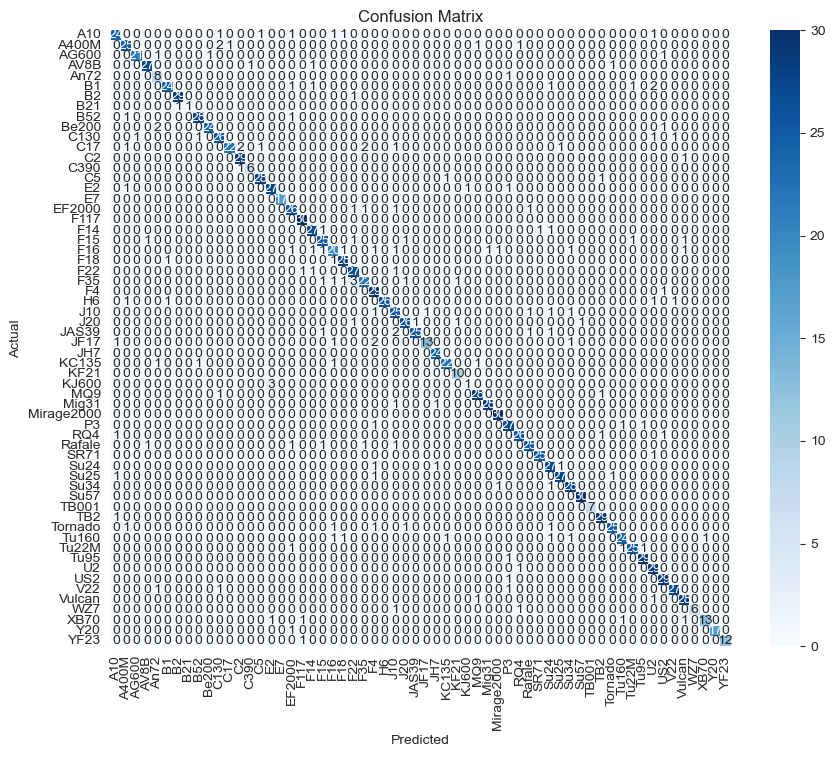

1/1 [==============================] - 2s 2s/step


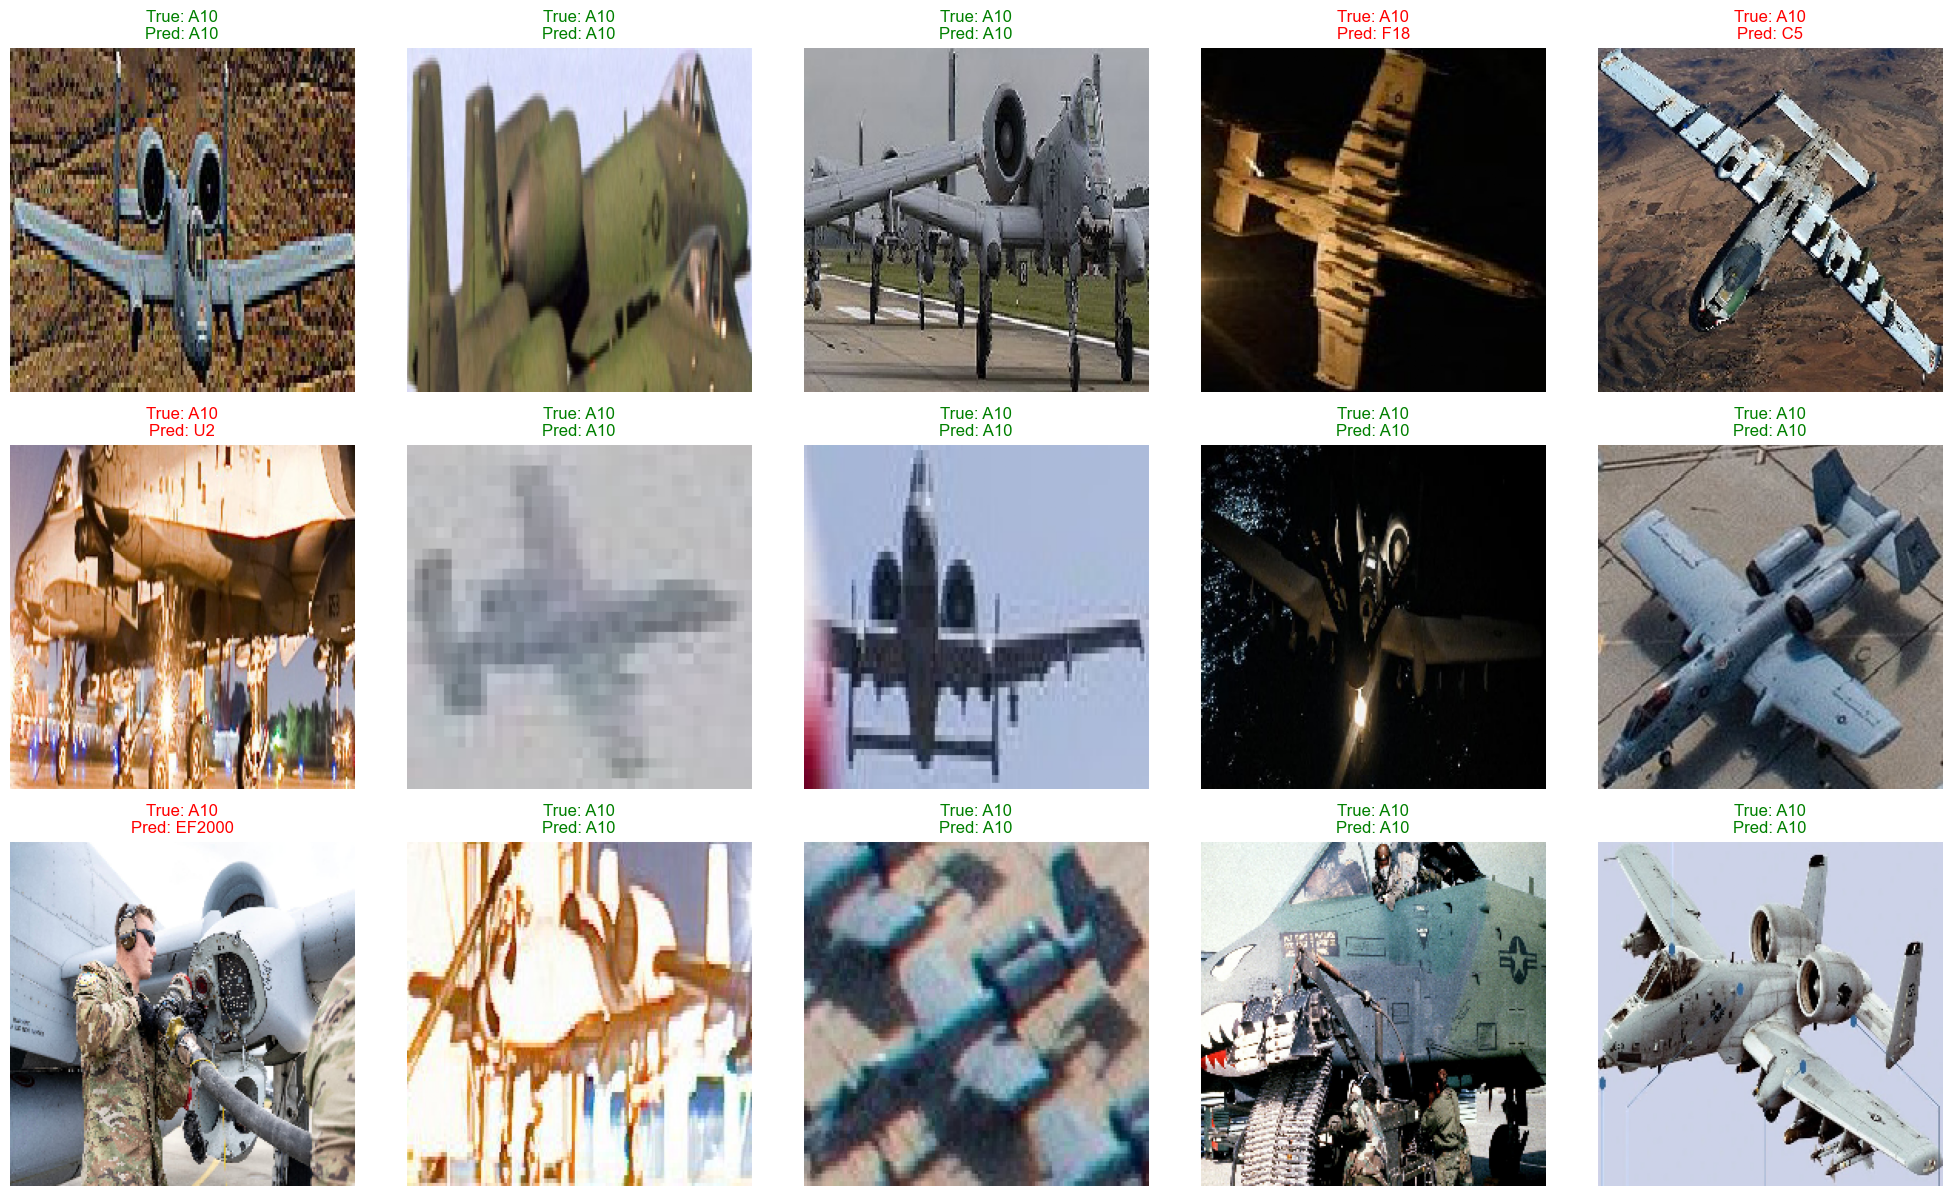

Evaluating ResNet50 Model:
49/49 [==============================] - 9s 178ms/step
Classification Report:
              precision    recall  f1-score   support

         A10       0.78      0.70      0.74        30
       A400M       0.96      0.77      0.85        30
       AG600       0.91      0.83      0.87        24
        AV8B       0.79      0.87      0.83        30
        An72       1.00      0.56      0.71         9
          B1       0.68      0.77      0.72        30
          B2       0.87      0.90      0.89        30
         B21       1.00      0.50      0.67         2
         B52       0.72      0.87      0.79        30
       Be200       0.92      0.89      0.91        27
        C130       0.71      0.83      0.77        30
         C17       0.76      0.87      0.81        30
          C2       0.90      0.87      0.88        30
        C390       1.00      0.29      0.44         7
          C5       0.70      0.87      0.78        30
          E2       0.86      0

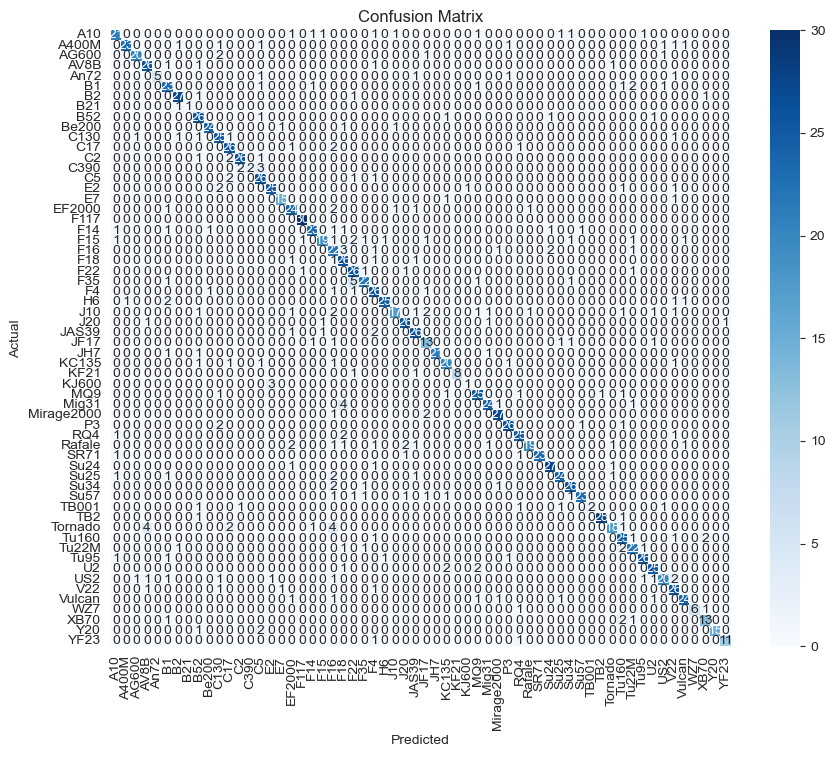

1/1 [==============================] - 1s 955ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5263569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4850196..0.5923961].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077176

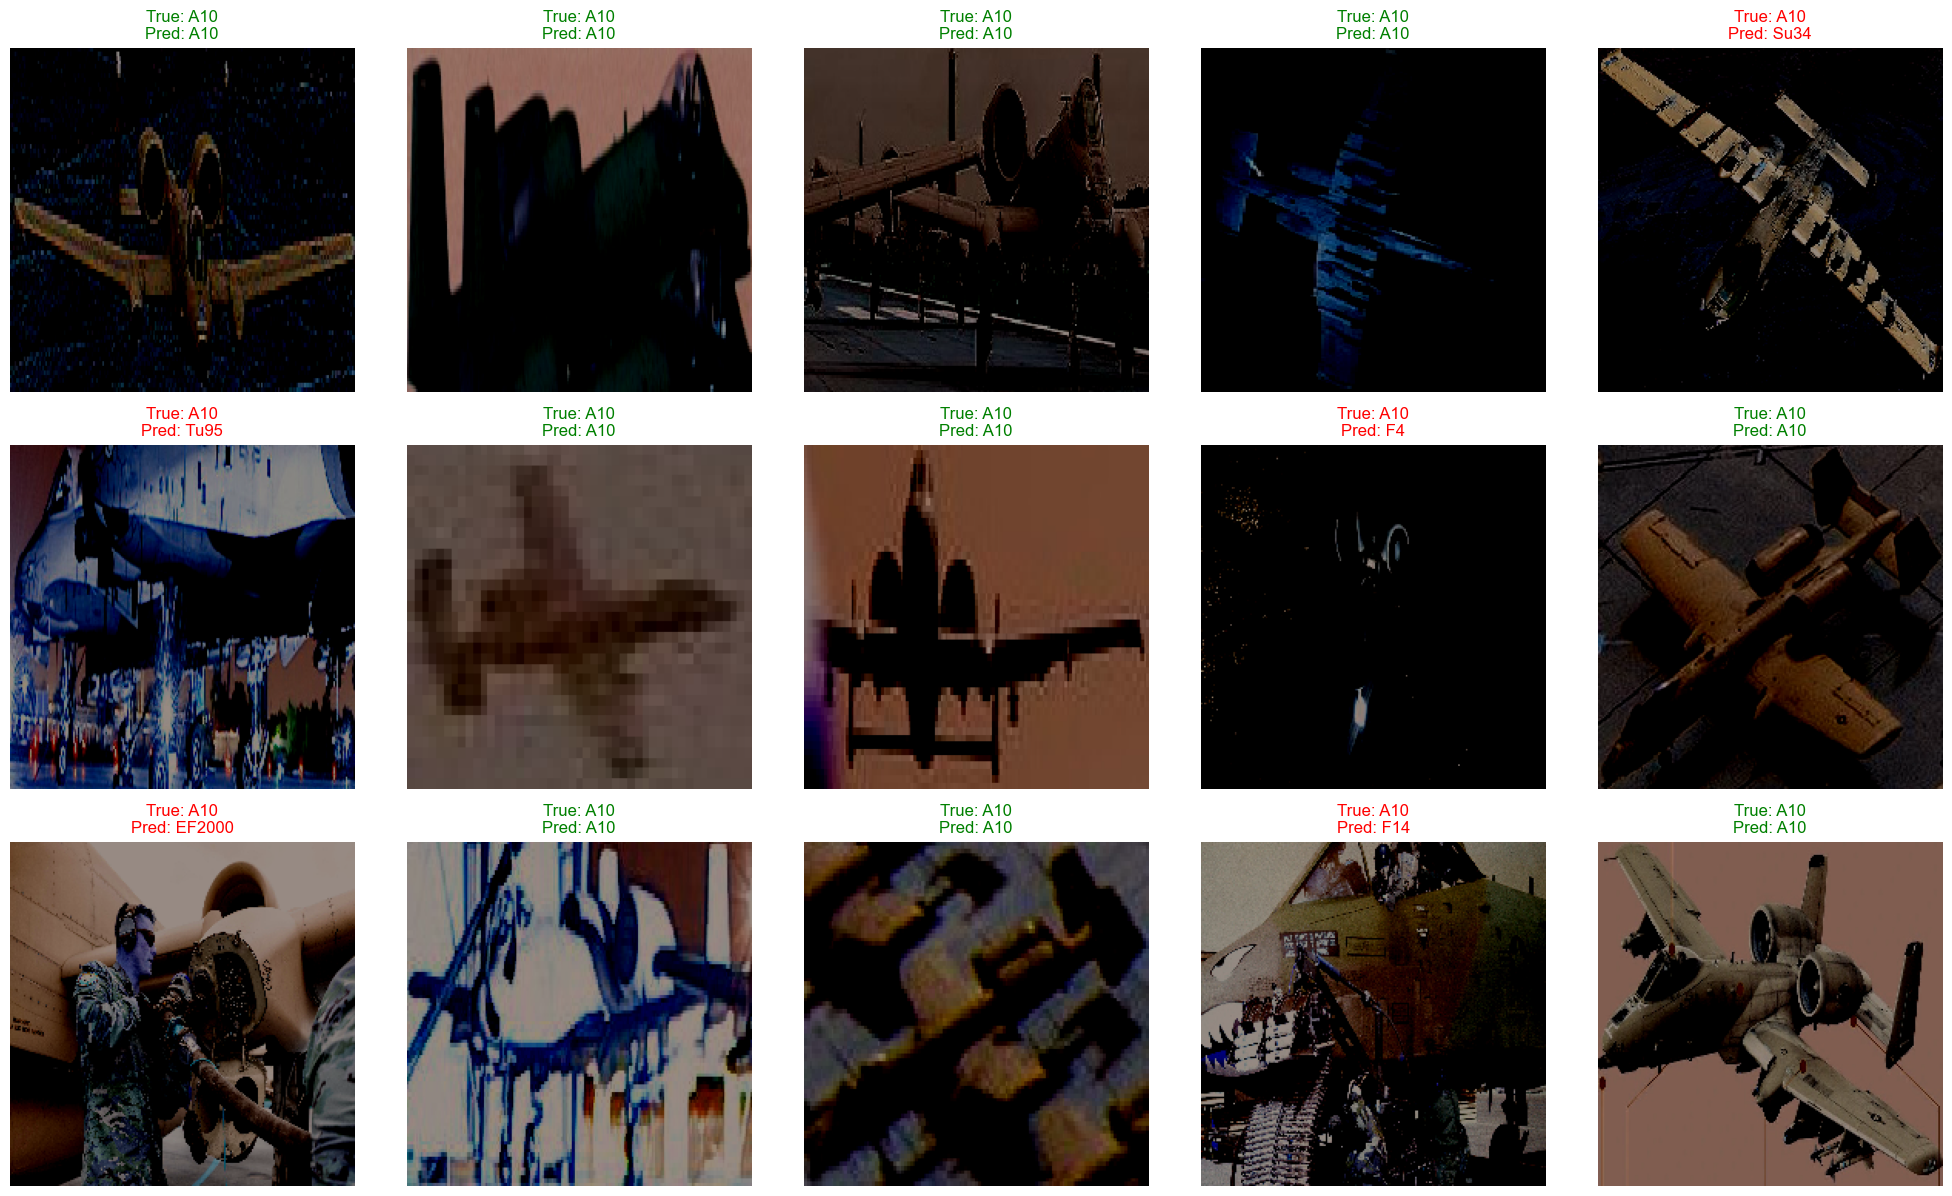

In [20]:
# Evaluate EfficientNetB3 model
print("Evaluating EfficientNetB3 Model:")
evaluate_model(efficientnet_model, test_gen_eff)

# Display sample predictions for EfficientNetB3
display_predictions(test_gen_eff, efficientnet_model, num_images=15)

# Evaluate ResNet50 model
print("Evaluating ResNet50 Model:")
evaluate_model(resnet_model, test_gen_resnet)

# Display sample predictions for ResNet50
display_predictions(test_gen_resnet, resnet_model, num_images=15)


## Save Models and Class Indices

In [21]:
# Save EfficientNetB3 model
efficientnet_model.save('../reports/models/efficientnet_model.h5')
print("EfficientNetB3 model saved as 'efficientnet_model.h5'")

# Save ResNet50 model
resnet_model.save('../reports/models/resnet_model.h5')
print("ResNet50 model saved as 'resnet_model.h5'")

# Save class indices and image size
class_indices = train_gen_eff.class_indices
img_size = train_gen_eff.image_shape[:2]

class_df = pd.DataFrame({
    'class_index': list(class_indices.values()),
    'class': list(class_indices.keys()),
    'height': img_size[0],
    'width': img_size[1]
})

class_df.to_csv('class_indices.csv', index=False)
print("Class indices saved as 'class_indices.csv'")

EfficientNetB3 model saved as 'efficientnet_model.h5'
ResNet50 model saved as 'resnet_model.h5'
Class indices saved as 'class_indices.csv'
